In [9]:
import random
import pandas as pd
import time
import datetime
import os
import numpy as np
from calendar import isleap
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from ngboost.api import NGBRegressor
from ngboost.distns import Normal
from ngboost.scores import MLE
from ngboost.evaluation import *
from scipy import stats
from scipy.stats import norm, skew
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import MinMaxScaler
from time import time
from pprint import pprint
import shap
shap.initjs()
import os

In [10]:
def read_tabular_data(file_name, base_dir):
    df = os.path.join(base_dir, file_name)
    df_read = pd.read_excel(df, thousands=r',')
    return df_read

In [11]:
base_dir = r"/Users/itdeveloper/AI workspace/Course/construction-cost-prediction"
filename = r"dataset.xlsx"
data_df = read_tabular_data(filename, base_dir)

#drop missing data dari dataframe
data_df = data_df[data_df['Total Cost [\$/$ft^2$]'] !=0 ]
data_df.dropna(inplace=True)
data_df.to_excel("dataset_no_zero.xlsx")

data_df.head()

,Type,Tributary Area [$ft^2$],Superimposed Load [lbs./$ft^2$],Formwork [\$/$ft^2$],Concrete [\$/$ft^3$],Total Cost [\$/$ft^2$]
0,1,225,40,4.384787,2.105263,9.87
1,1,225,75,4.384787,2.105263,9.96
2,1,225,125,4.384787,2.105263,10.07
3,1,225,200,4.384787,2.105263,10.49
4,1,300,40,4.384787,2.105263,9.82


In [12]:
data_df.describe()

,Type,Tributary Area [$ft^2$],Superimposed Load [lbs./$ft^2$],Formwork [\$/$ft^2$],Concrete [\$/$ft^3$],Total Cost [\$/$ft^2$]
count,4477.000000,4477.000000,4477.000000,4477.000000,4477.000000,4477.000000
mean,3.589681,763.122627,107.044896,7.427951,3.545461,16.810920
std,1.781348,421.868634,58.797915,2.275921,0.957371,4.322783
min,1.000000,225.000000,40.000000,4.194631,1.730000,7.700000
25%,2.000000,400.000000,40.000000,5.877016,2.720721,13.380000
50%,4.000000,625.000000,75.000000,6.790000,3.821510,16.700000
75%,5.000000,1050.000000,125.000000,8.729282,4.217391,20.000000
max,6.000000,1800.000000,200.000000,13.750000,5.225225,29.750000


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


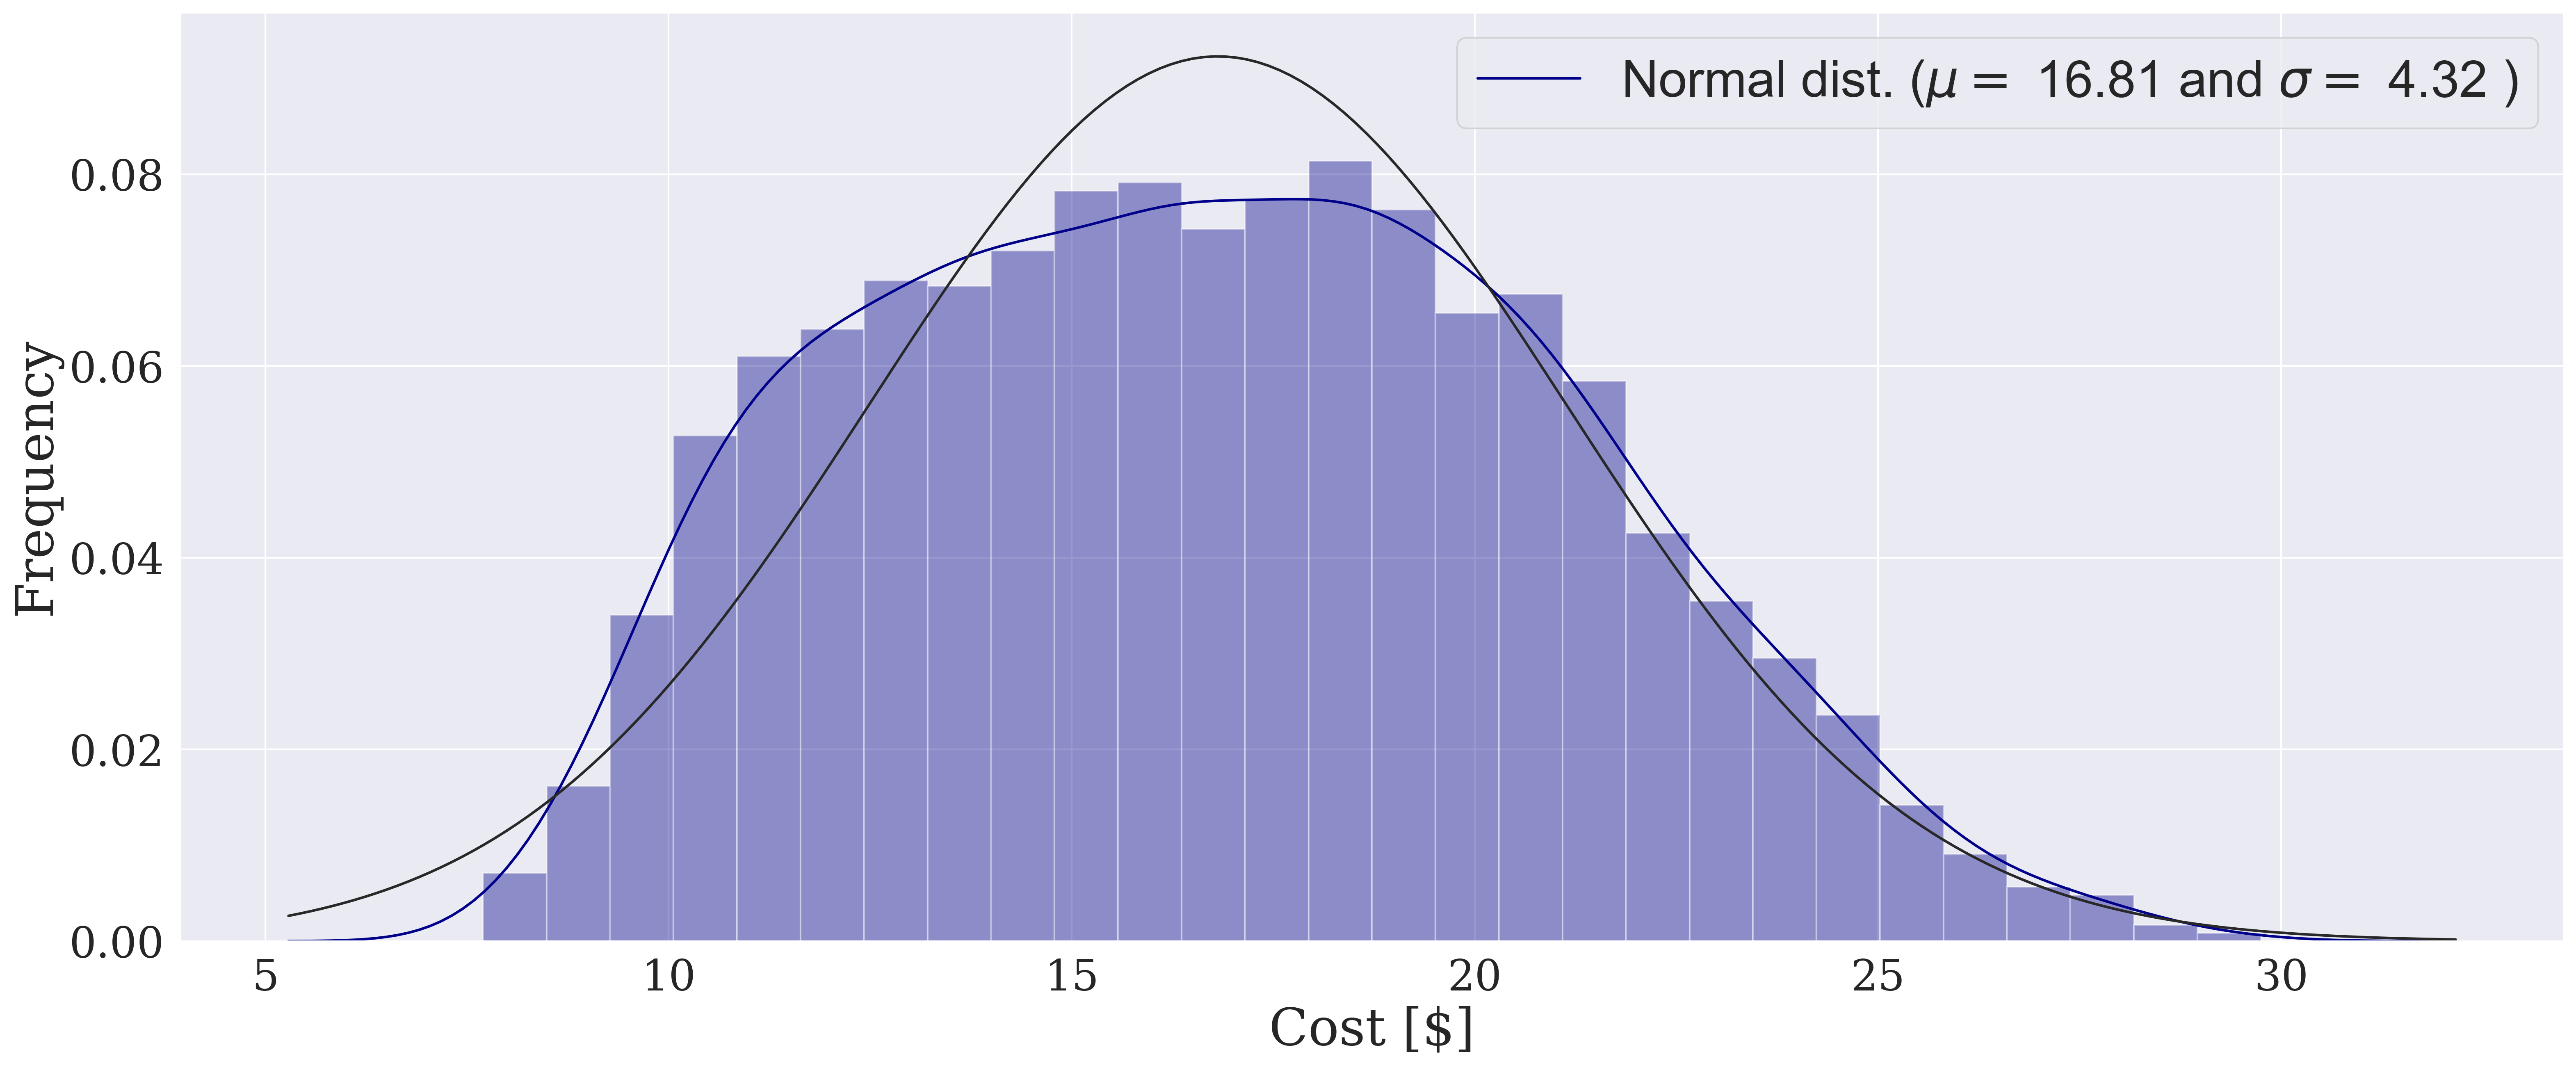

In [13]:
fig = plt.figure(figsize=(25,10),dpi=300)
sns.distplot(data_df['Total Cost [\$/$ft^2$]'], fit = norm, color='darkblue')
(mu, sigma) = norm.fit(data_df['Total Cost [\$/$ft^2$]'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=30)
plt.xlabel('Cost [$]', fontsize=30, fontname='Serif')
plt.ylabel('Frequency', fontsize=30, fontname='Serif')
plt.xticks(fontsize=25, fontname='Serif')
plt.yticks(fontsize=25, fontname='Serif')
plt.figaspect(1.)
plt.title('')
plt.savefig('Assembly Cost Distribution.pdf')

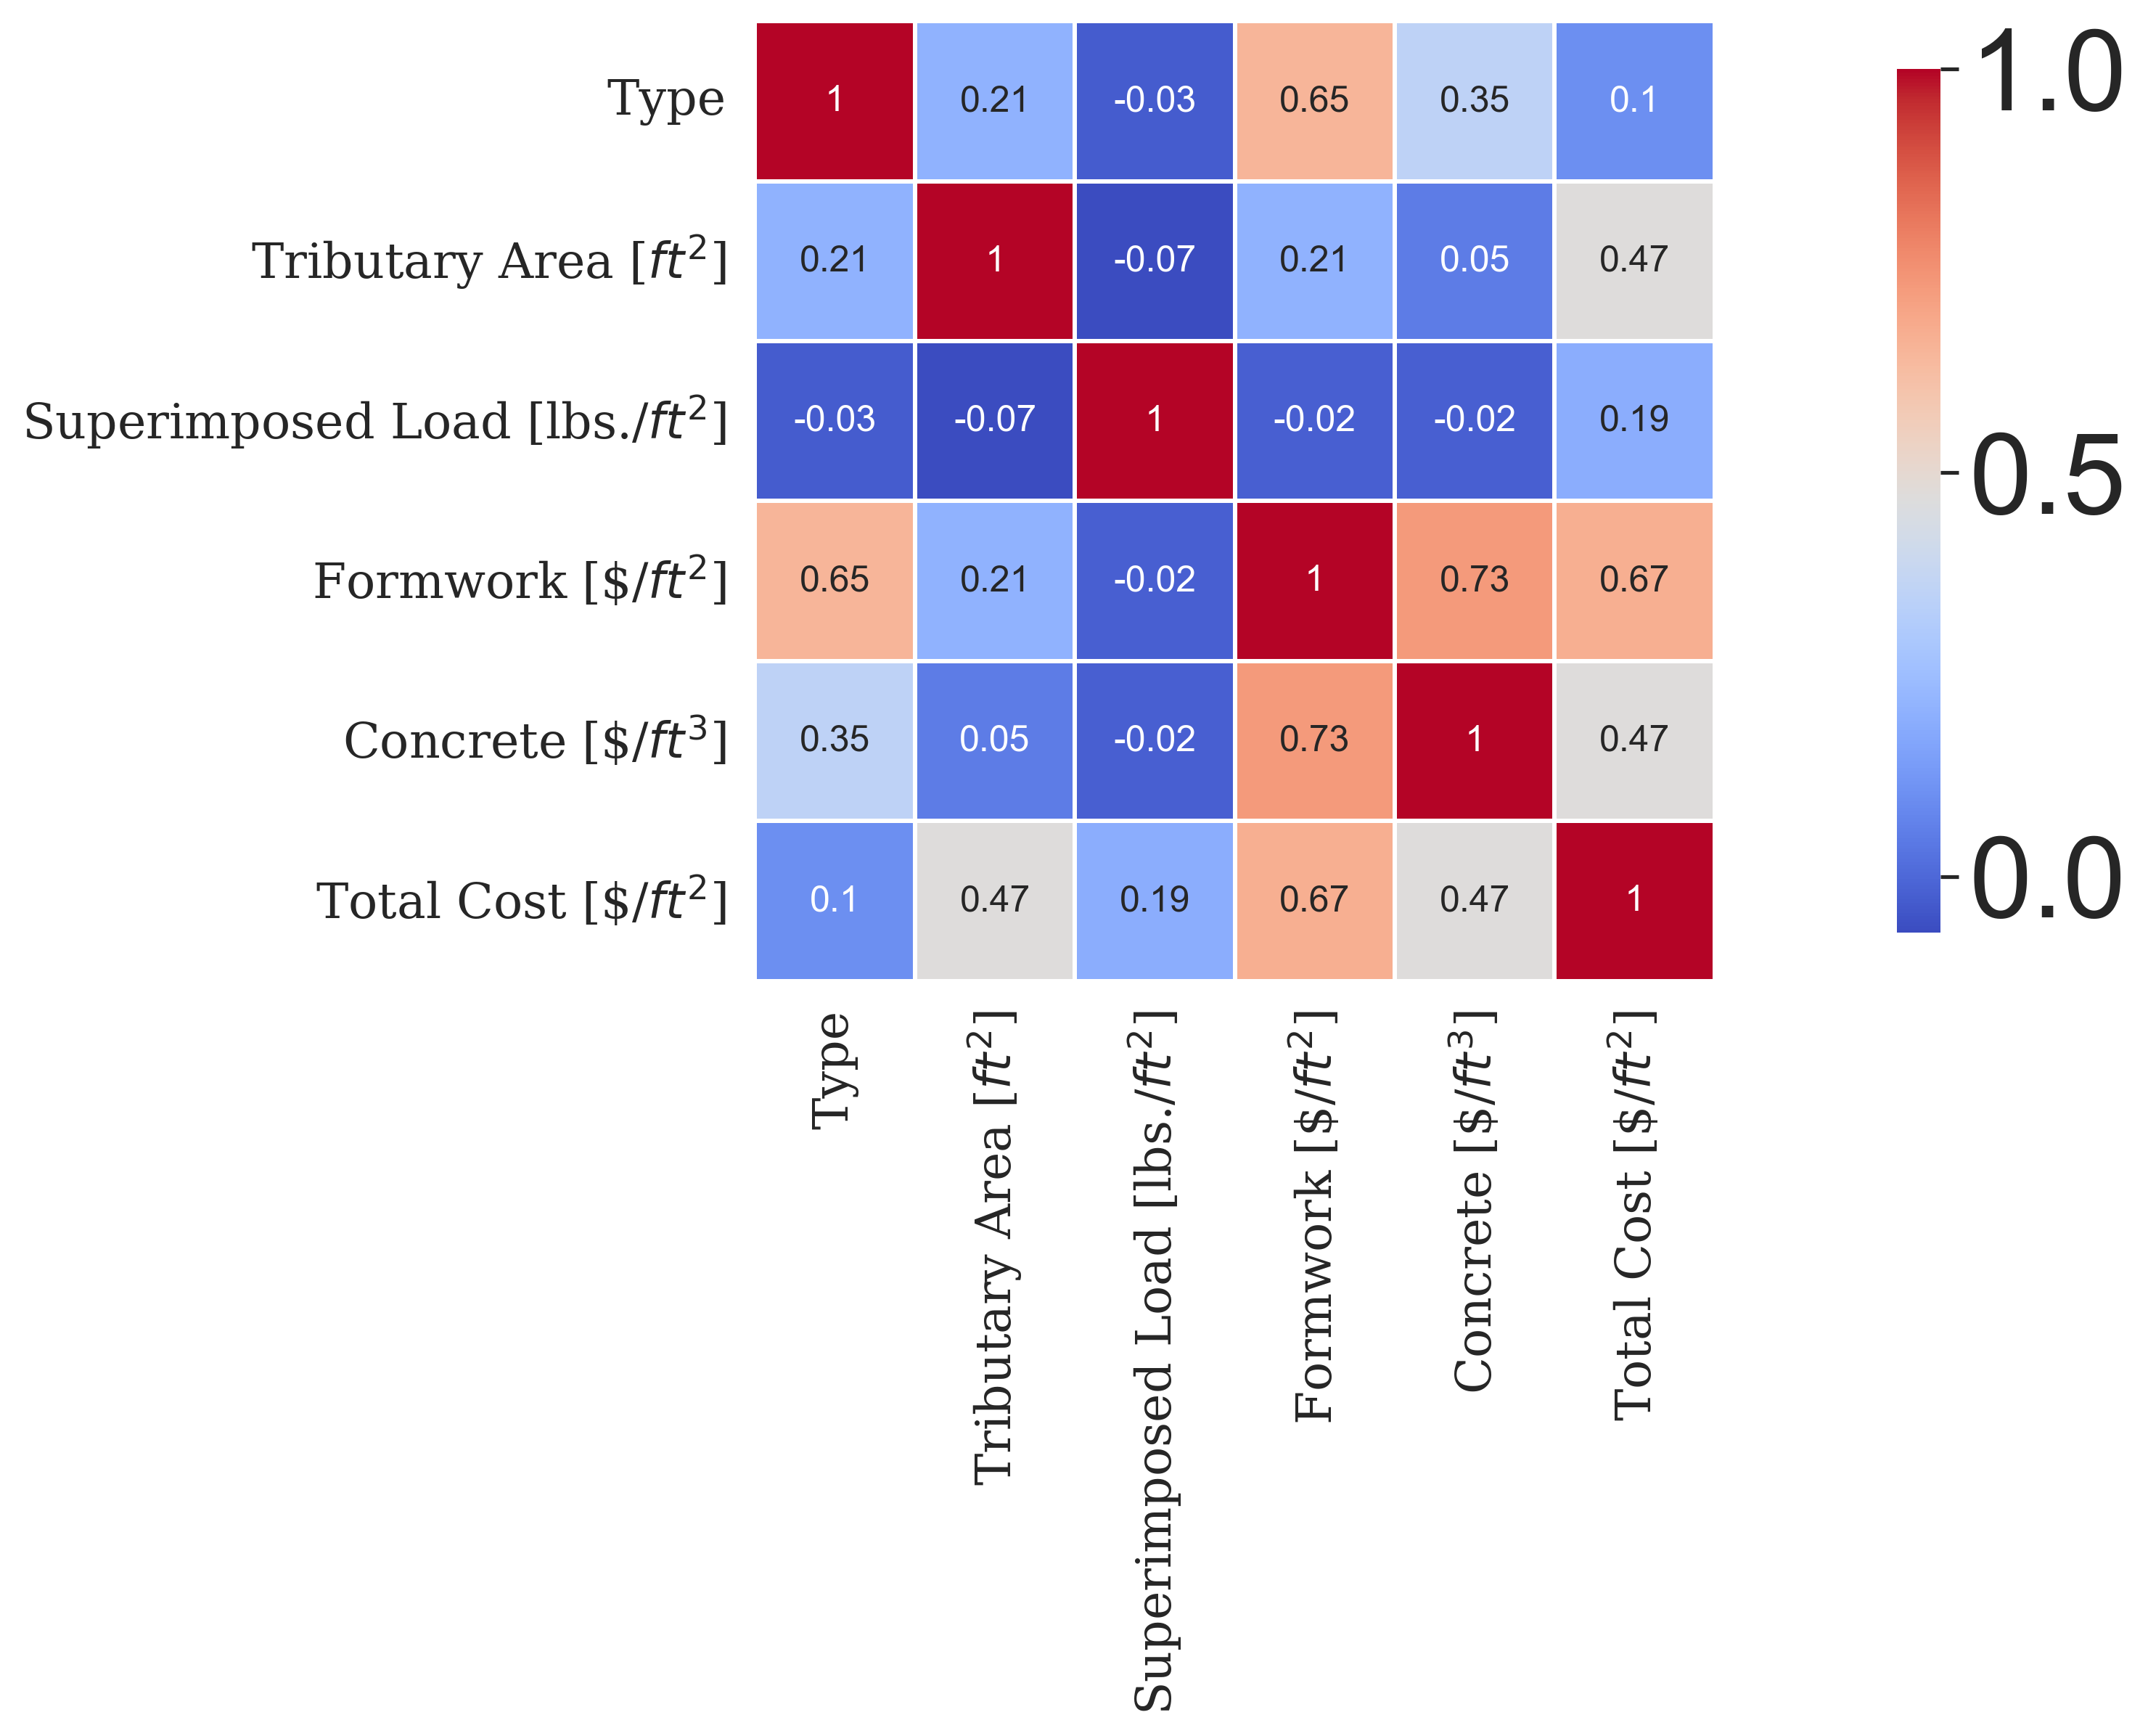

In [14]:
single_variate_corr_1 = data_df.corr('pearson')
fig = plt.figure(figsize=(18,9),dpi=300)
sns.set(font_scale=3.4)
sns.heatmap(np.round(single_variate_corr_1,2), vmax=1, square=True, linewidths=1, annot=True, annot_kws={"size": 12},
            cbar_kws={"shrink": .9}, cmap='coolwarm')
plt.xticks(fontsize=16, fontname='Serif', rotation=90)
plt.yticks(fontsize=16, fontname='Serif')
plt.figaspect(1.)
plt.title('')
plt.tight_layout(pad=1.08)
fig.savefig('Correlation Heaatmap.pdf', format='pdf', dpi=300, bbox_inches= 'tight')

In [21]:


Feature_Names = ['Type', 'Tributary Area [$ft^2$]', 'Superimposed Load [lbs./$ft^2$]', 'Formwork [\$/$ft^2$]', 
                 'Concrete [\$/$ft^3$]']

X = data_df[Feature_Names].to_numpy()
y = data_df['Total Cost [\$/$ft^2$]'].to_numpy()
#################################################################################################
# To test the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=7)
#################################################################################################
# Feature scaling required for neural network
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(y_train.reshape(-1, 1))
scaled_y_train = scaler.transform(y_train.reshape(-1, 1))
scaled_y_test = scaler.transform(y_test.reshape(-1, 1))
#################################################################################################
np.random.seed(7)
scoring_param = make_scorer(mean_squared_error,greater_is_better=False)
#################################################################################################



# Neural Network

In [24]:
n_features = scaled_x_train.shape[1]
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse')

t0 = time()

history = model.fit(scaled_x_train, scaled_y_train, epochs=150, batch_size=32, verbose=0, use_multiprocessing=True)

t1 = time()
Time_Taken = (t1-t0)/60
print("Time taken to train the model: %0.2f" % Time_Taken,"minutes")

#----------------------------------------------------------------------------------------------------------
#  nilai min, max cost dalam data training
#----------------------------------------------------------------------------------------------------------
ymin = min(y_train)
ymax = max(y_train)

multiplier = ymax - ymin
#----------------------------------------------------------------------------------------------------------
# evaluasi model pada data training
#----------------------------------------------------------------------------------------------------------
Y_hat = model.predict(scaled_X_train)

Y_Train_Pred = (ymin + Y_hat * multiplier)

rmse = np.sqrt(mean_squared_error(y_train,Y_Train_Pred))
RSQ = r2_score(y_train,Y_Train_Pred)
MBE = np.mean(y_train - Y_Train_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")
#----------------------------------------------------------------------------------------------------------
# evaluasi model pada data testing
#----------------------------------------------------------------------------------------------------------
Y_hat = model.predict(scaled_X_test)

Y_Test_Pred = (ymin + Y_hat * multiplier)

rmse = np.sqrt(mean_squared_error(y_test,Y_Test_Pred))
RSQ = r2_score(y_test,Y_Test_Pred)
MBE = np.mean(y_test - Y_Test_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")


Time taken to train the model: 0.18 minutes
############ Model Accuracy on Daily Testing Data ############
RMSE: 0.771
R-squared: 0.968
MBE: -0.002
########################################
 
############ Model Accuracy on Daily Testing Data ############
RMSE: 0.850
R-squared: 0.961
MBE: -0.007
########################################
 


# Linear Regresion

In [26]:
t0 = time()

lin_reg = LinearRegression(normalize=True).fit(X_train, y_train)

t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")

Y_Train_Pred = lin_reg.predict(X_train)

rmse = np.sqrt(mean_squared_error(y_train.ravel(),Y_Train_Pred))
RSQ = r2_score(y_train.ravel(),Y_Train_Pred)
MBE = np.mean(y_train.ravel() - Y_Train_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Training Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Y_Test_Pred = lin_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred)
MBE = np.mean(y_test.ravel() - Y_Test_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")
################################################################
################################################################
print("############ Model Coefficients ############")
print(np.round((lin_reg.coef_),2))

Time taken to train the model: 0.00 seconds
############ Model Accuracy on Daily Training Data ############
RMSE: 1.750
R-squared: 0.836
MBE: 0.000
########################################
 
############ Model Accuracy on Daily Testing Data ############
RMSE: 1.792
R-squared: 0.827
MBE: 0.102
########################################
 
############ Model Coefficients ############
[-1.53  0.    0.02  2.02 -0.42]


'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)




# Random Forest

In [27]:
t0 = time()

p_grid = dict(n_estimators = [int(i) for i in np.linspace(100,2000,num=20)],
    max_depth = [int(i) for i in np.linspace(1,10,num=10)],
  min_samples_leaf = [int(i) for i in np.linspace(1,10,num=10)])

rf = GridSearchCV(estimator = RandomForestRegressor(random_state=7), param_grid = p_grid, 
                     scoring = scoring_param, cv = 3, verbose=1, n_jobs=-1)

rf.fit(X_train, y_train.ravel())

t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")
print("Best RF Estimators: %0.3f" % rf.best_params_.get('n_estimators'))
print("Best RF Max Depth: %0.3f" % rf.best_params_.get('max_depth'))
print("Best RF Min Samples in Leaf: %0.3f" % rf.best_params_.get('min_samples_leaf'))

Y_Train_Pred = rf.predict(X_train)

rmse = np.sqrt(mean_squared_error(y_train.ravel(),Y_Train_Pred))
RSQ = r2_score(y_train.ravel(),Y_Train_Pred)
MBE = np.mean(y_train.ravel() - Y_Train_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Training Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Y_Test_Pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred)
MBE = np.mean(y_test.ravel() - Y_Test_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits


# XGBoost

In [ ]:
t0 = time()

p_grid = dict(n_estimators = [int(i) for i in np.linspace(100,200,num=20)], 
        max_depth = [int(i) for i in np.linspace(1,10, num=10)],
        learning_rate = np.linspace(0.001,0.1,num=10))

xgb = GridSearchCV(estimator = XGBRegressor(random_state=7), param_grid=p_grid, scoring=scoring_param, cv=3, verbose=2, n_job=-1)

xgb.fit(X_train, y_train.ravel())

t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken, "seconds")
print("Best XGB Estimators: %0.3f" % xgb.best_params_.get('n_estimators')
print("Best XGB Max Depth: %0.3f" % xgb.best_params_.get('max_depth')
print("Best XGB BEst Learning Rate: %0.3f" % xgb.best_params_.get('learning_rate')

Y_Train_Pred xgb.predict(x_train)

rmse = np.sqrt(mean_squared_error(y_train.ravel(), Y_Train_Pred)
RSO = r2_score(y_train.ravel(), Y_Train_Pred)
MBE = np.mean(y_train.ravel(), Y_Train_Pred)

################################################################
################################################################

print("###### Akurasi model pada data training harian ######")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE : %0.3f" % MBE)
print("#########################################")
print(" ")

Y_Test_Pred = xgb.predict(X_test))

rmse = np.sqrt(mean_squared_error(y_test.ravel(), Y_Test_Pred())
RSQ = r2_score(y_test.ravel(), Y_Test_Pred)
MBE = np.mean(y_test.ravel() - Y_Test_Pred)

################################################################
################################################################

print("###### Akurasi model pada data training harian ######")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("#####################################################")
print(" ")

# Light GBM

In [ ]:
t0 = time()

p_grid = dict(n_estimators = [int(i) for i in np.linspace(100,2000,num=20)],
    max_depth = [int(i) for i in np.linspace(1,10,num=10)],
  learning_rate = np.linspace(0.001,0.1,num=10))

lgb = GridSearchCV(estimator = LGBMRegressor(random_state=7), param_grid = p_grid, 
                     scoring = scoring_param, cv = 3, verbose=1, n_jobs=-1)

lgb.fit(X_train, y_train.ravel())

t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")
print("Best LGB Estimators: %0.3f" % lgb.best_params_.get('n_estimators'))
print("Best LGB Max Depth: %0.3f" % lgb.best_params_.get('max_depth'))
print("Best LGB Learning Rate: %0.3f" % lgb.best_params_.get('learning_rate'))

Y_Train_Pred = lgb.predict(X_train)

rmse = np.sqrt(mean_squared_error(y_train.ravel(),Y_Train_Pred))
RSQ = r2_score(y_train.ravel(),Y_Train_Pred)
MBE = np.mean(y_train.ravel() - Y_Train_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Training Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

Y_Test_Pred = lgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred)
MBE = np.mean(y_test.ravel() - Y_Test_Pred)
################################################################
################################################################
print("############ Model Accuracy on Daily Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("########################################")
print(" ")

# Natural GBM

In [ ]:
t0 = time()

p_grid = dict(n_estimators = [int(i) for i in np.linspace(100,2000,num=20)],
              minibatch_frac = np.linspace(0.1,1,num=10),
              learning_rate = np.linspace(0.01,0.1,num=10))

ngb = GridSearchCV(estimator = NGBRegressor(random_state=7), param_grid = p_grid, 
                     scoring = scoring_param, cv = 3, verbose=1, n_jobs=-1)

ngb.fit(X_train, y_train.ravel())

t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")
print("Best NGB Estimators: %0.3f" % ngb.best_params_.get('n_estimators'))
print("Best NGB Minibatch Fraction: %0.3f" % ngb.best_params_.get('minibatch_frac'))
print("Best NGB Learning Rate: %0.3f" % ngb.best_params_.get('learning_rate'))

ngb = NGBRegressor(n_estimators = ngb.best_params_.get('n_estimators'), minibatch_frac = ngb.best_params_.get('minibatch_frac'),
                   learning_rate = ngb.best_params_.get('learning_rate'), random_state=7)

ngb.fit(X_train, y_train.ravel())

Y_Train_Pred = ngb.pred_dist(X_train)

rmse = np.sqrt(mean_squared_error(y_train.ravel(), Y_Train_Pred.dist.mean()))
RSQ = r2_score(y_train.ravel(), Y_Train_Pred.dist.mean())
MBE = np.mean(y_train.ravel() - Y_Train_Pred.loc)
################################################################
UB = (Y_Train_Pred.loc + 1.96 * Y_Train_Pred.scale)
LB = (Y_Train_Pred.loc - 1.96 * Y_Train_Pred.scale)
count = 0
n = len(y_train)
for i in range(n):
    if (y_train[i] <= UB[i] and y_train[i] >= LB[i]):
#         print(i)
        count = count + 1

Acc = 100*count/n
################################################################
print("############ Model Accuracy ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("# of points inside PI: %0.1f" % Acc,"%")
print("########################################")
print(" ")

Y_Test_Pred = ngb.pred_dist(X_test)

rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred.loc))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred.loc)
MBE = np.mean(y_test.ravel() - Y_Test_Pred.loc)
################################################################
UB = (Y_Test_Pred.loc + 1.96 * Y_Test_Pred.scale)
LB = (Y_Test_Pred.loc - 1.96 * Y_Test_Pred.scale)
count = 0
n = len(y_test)
for i in range(n):
    if (y_test[i] <= UB[i] and y_test[i] >= LB[i]):
#         print(i)
        count = count + 1

Acc = 100*count/n
################################################################
print("############ Model Accuracy on Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("# of points inside PI: %0.1f" % Acc,"%")
print("########################################")
print(" ")

# NGB default

In [ ]:
t0 = time()

ngb_default = NGBRegressor(random_state=7)

ngb_default.fit(X_train, y_train.ravel())

t1 = time()
Time_Taken = (t1-t0)
print("Time taken to train the model: %0.2f" % Time_Taken,"seconds")

Y_Train_Pred = ngb_default.pred_dist(X_train)

rmse = np.sqrt(mean_squared_error(y_train.ravel(), Y_Train_Pred.dist.mean()))
RSQ = r2_score(y_train.ravel(), Y_Train_Pred.dist.mean())
MBE = np.mean(y_train.ravel() - Y_Train_Pred.loc)
################################################################
UB = (Y_Train_Pred.loc + 1.96 * Y_Train_Pred.scale)
LB = (Y_Train_Pred.loc - 1.96 * Y_Train_Pred.scale)
count = 0
n = len(y_train)
for i in range(n):
    if (y_train[i] <= UB[i] and y_train[i] >= LB[i]):
#         print(i)
        count = count + 1

Acc = 100*count/n
################################################################
print("############ Model Accuracy ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("# of points inside PI: %0.1f" % Acc,"%")
print("########################################")
print(" ")

Y_Test_Pred = ngb_default.pred_dist(X_test)

rmse = np.sqrt(mean_squared_error(y_test.ravel(),Y_Test_Pred.loc))
RSQ = r2_score(y_test.ravel(),Y_Test_Pred.loc)
MBE = np.mean(y_test.ravel() - Y_Test_Pred.loc)
################################################################
UB = (Y_Test_Pred.loc + 1.96 * Y_Test_Pred.scale)
LB = (Y_Test_Pred.loc - 1.96 * Y_Test_Pred.scale)
count = 0
n = len(y_test)
for i in range(n):
    if (y_test[i] <= UB[i] and y_test[i] >= LB[i]):
#         print(i)
        count = count + 1

Acc = 100*count/n
################################################################
print("############ Model Accuracy on Testing Data ############")
print("RMSE: %0.3f" % rmse)
print("R-squared: %0.3f" % RSQ)
print("MBE: %0.3f" % MBE)
print("# of points inside PI: %0.1f" % Acc,"%")
print("########################################")
print(" ")

# Actual Cost Vs Predicted Cost

In [ ]:
# fig = plt.figure(figsize=(14,7),dpi=300)
# ax = fig.add_subplot(1,1,1,facecolor='ivory')
# sns.regplot(y_test, lgb.predict(X_test), x_ci='ci', label = 'Actual vs. predicted cost',
#             scatter_kws={'color': 'blue', 's': 70},
#             line_kws={'color': 'darkgreen', 'linewidth': 3, 'label': 'Best fit line'})

# sns.lineplot(y_test, ngb_default.pred_dist(X_test).loc - 1.96 * ngb_default.pred_dist(X_test).scale, color = "black", 
#              linestyle = "--", linewidth=3, ci =None)
# sns.lineplot(y_test, ngb_default.pred_dist(X_test).loc + 1.96 * ngb_default.pred_dist(X_test).scale, color = "black", 
#              linestyle = "--", linewidth=3, ci =None, label = '95% prediction interval')
# plt.xlabel("Actual Cost [\$/$ft^2$]", fontsize=25, fontname='Serif')
# plt.ylabel("Predicted Cost [\$/$ft^2$]", fontsize=25, fontname='Serif')
# plt.xticks(fontsize=18, fontname='Serif')
# plt.yticks(fontsize=18, fontname='Serif')
# plt.figaspect(1.)
# plt.legend(bbox_to_anchor=(0,1.02), loc="lower left", ncol=3, borderaxespad=0., prop={'size': 21})
# plt.tight_layout(pad=1.08)
# plt.savefig('Final Scatter Plot.pdf', format='pdf', dpi=300, bbox_inches = 'tight')

In [ ]:
fig = plt.figure(figsize(14,7),dpi=300)
ax = fig.add_subplot(1,1,1,facecolor='ivory')
sns.regplot(y_test, lgb.predict(X_test), x_ci='ci', label ='Actual vs. predicted cost',
            scatter_kws={'color': 'blue', 's': 70},
            line_kws = {'color': 'darkgreen', 'linewidth': 3, 'label': 'Best fit line'})
sns.lineplot(y_test, ngb_default.pred_dist(X_test).loc - 1.96 * ngb_default.pred_dist(X_test).scale, color="black",
            linestyle= "--", linewidth=3, ci=None")
sns.lineplot(y_test, ngb_default.pred_dist(X_test), loc + 1.96 * ngb_default.pred_dist(X_test).scale, color = "black",
            linestyle= "--", linewidth=3, ci=None, label = '95% prediction interval')
plt.xlabel("Actual Cost [\$/$ft^2$]", fontsize=25, fontname='Serif')
plt.ylabel("Predicted Cost [\$/$ft^2$]", fontsize=25, fontname='Serif')
plt.xticks(fontsize=18, fontname='Serif')
plt.yticks(fontsize=18, fontname='Serif')
plt.figaspect(1.)
plt.legend(bbox_to_anchor=(0,1.02), loc="lower left", ncol=3, borderaxespad=0., prop={'size': 21})
plt.tight_layout(pad=1.08)
plt.savig('Final Scatter Plot.pdf', format='pdf', dpi=300, bbox_inches='tight')

In [ ]:
# lgb_shap = LGBMRegressor(n_estimators=lgb.best_params_.get('n_estimators'),max_depth=lgb.best_params_.get('max_depth'),
#                          learning_rate=lgb.best_params_.get('learning_rate'))

# lgb_shap.fit(X, y.ravel())

# explainer = shap.TreeExplainer(lgb_shap)
# shap_values = explainer.shap_values(Data_DF[Feature_Names].to_numpy())

# shap.summary_plot(shap_values, Data_DF[Feature_Names].to_numpy(), Feature_Names, plot_size=(16,8), show=False)
# plt.xlabel('Shapley Values - Impact on model', fontsize=30)
# plt.tick_params(labelsize=30)
# plt.savefig('Feature Importance - SHAP.pdf', format='pdf', dpi=300, bbox_inches = 'tight'

In [ ]:
lgb_shap = LGBMRegressor(n_estimators=lgb.best_params_.get('n_estimators'), max_depth=lgb.best_params_.get('max_depth'),
                        learning_rate = lgb.best_params_.get('learning_rate'))
lgb_shap.fit(X, y.ravel())

explainer = shap.TreeExplainer(lgb_shap)
shap_values = explainer.shap_values(data_df[Feature_Names].to_numpy(), Feature_Names, plot_size=(16,8), show=False)
plot.xlabel('Shapley Values - Impact on model', fontsize=30)
plt.tick_params(labelsize=30)
plt.savefig('Feature Importance - SHAP.pdf', format='pdf', dpi=300, bbox_incehs = 'tigh')

In [ ]:
# shap.force_plot(explainer.expected_value, shap_values, Data_DF[Feature_Names].to_numpy())

In [ ]:
# fig = plt.figure(figsize=(7,5),dpi=300)
# ax1 = fig.add_subplot(1,1,1)

# shap.dependence_plot('Type',shap_values, Data_DF[Feature_Names].to_numpy(),Feature_Names, ax=ax1, show=False)

# plt.savefig('Feature Interaction - Type.pdf', format='pdf', dpi=300, bbox_inches = 'tight')

In [ ]:
shap.force_plot(explainer.expected_value, shap_value, data_df[Feature_Names].to_numpy())

In [ ]:
fig = plt.figure(figsize=(7,5), dpi=300)
ax1 = fig.add_subplot(1,1,1)

shap.dependence_plot('Type', shap_values, data_df[Feature_Names].to_numpy(), Feature_Names, ax=ax1, show=False)

plt.savefig('Feature Interaction - Type.pdf', format='pdf', dpi=300, bbox_inches = 'tight')

In [ ]:
fig = plt.figure(figsize=(7,5),dpi=300)
ax1 = fig.add_subplot(1,1,1)

shap.dependence_plot('Tributary Area [$ft^2$]',shap_values, data_df[Feature_Names].to_numpy(),Feature_Names, ax=ax1, show=False)

plt.savefig('Feature Interaction - Area.pdf', format='pdf', dpi=300, bbox_inches = 'tight')


In [ ]:
fig = plt.figure(figsize=(7,5),dpi=300)
ax1 = fig.add_subplot(1,1,1)

shap.dependence_plot('Superimposed Load [lbs./$ft^2$]',shap_values, data_df[Feature_Names].to_numpy(),Feature_Names, ax=ax1, show=False)

plt.savefig('Feature Interaction - Load.pdf', format='pdf', dpi=300, bbox_inches = 'tight')

In [ ]:
fig = plt.figure(figsize=(7,5),dpi=300)
ax1 = fig.add_subplot(1,1,1)

shap.dependence_plot('Formwork [\$/$ft^2$]',shap_values, data_df[Feature_Names].to_numpy(),Feature_Names, ax=ax1, show=False)

plt.savefig('Feature Interaction - Formwork.pdf', format='pdf', dpi=300, bbox_inches = 'tight')

In [ ]:
fig = plt.figure(figsize=(7,5),dpi=300)
ax1 = fig.add_subplot(1,1,1)

shap.dependence_plot('Concrete [\$/$ft^3$]',shap_values, data_df[Feature_Names].to_numpy(),Feature_Names, ax=ax1, show=False)

plt.savefig('Feature Interaction - Concrete.pdf', format='pdf', dpi=300, bbox_inches = 'tight')


In [ ]:
residuals = (np.concatenate((y_train.ravel(),y_test.ravel())) - np.concatenate((lgb.predict(X_train),lgb.predict(X_test))))
fig = plt.figure(figsize=(14,5))
sns.distplot(residuals, fit = norm, color='darkblue',kde=False,bins=250)
(mu, sigma) = norm.fit(residuals)
# plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=30)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
           bbox_to_anchor=(0,1.02), loc="lower left", ncol=3, borderaxespad=0., prop={'size': 21})
plt.xlabel('Residuals [\$/$ft^2$]', fontsize=30, fontname='Serif')
plt.ylabel('Frequency', fontsize=30, fontname='Serif')
plt.xticks(fontsize=25, fontname='Serif')
plt.yticks(fontsize=25, fontname='Serif')
plt.xlim(-2, 2)
plt.figaspect(1.)
plt.title('')
plt.savefig('Residual Distribution.pdf', format='pdf', dpi=300, bbox_inches = 'tight'

In [ ]:
residuals = (np.concatenate((y_train.ravel(),y_test.ravel())) - np.concatenate((lgb.predict(X_train),lgb.predict(X_test))))
fig = plt.figure(figsize=(14,5))
sns.distplot(residuals, fit = norm, color='darkblue',kde=False,bins=250)
(mu, sigma) = norm.fit(residuals)
# plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best', fontsize=30)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
           bbox_to_anchor=(0,1.02), loc="lower left", ncol=3, borderaxespad=0., prop={'size': 21})
plt.xlabel('Residuals [\$/$ft^2$]', fontsize=30, fontname='Serif')
plt.ylabel('Frequency', fontsize=30, fontname='Serif')
plt.xticks(fontsize=25, fontname='Serif')
plt.yticks(fontsize=25, fontname='Serif')
plt.xlim(-2, 2)
plt.figaspect(1.)
plt.title('')
plt.savefig('Residual Distribution.pdf', format='pdf', dpi=300, bbox_inches = 'tight'